In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt 
import sys
sys.path.append("..")
import src.config
output_name = "LastFourQuartersOrBestEstimate_On_DissolvedSmallerCitiesHexes.gpkg"
output_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries"

In [2]:
def convert_kbps_to_mbps(table, copy=False):
    if copy:
        table = table.copy()
    for col in table.columns:
        if "kbps" not in col:
            continue
        table.loc[:, col] /= 1000
        table.rename(columns={col: col.replace("kbps", "Mbps")}, inplace=True)
    return table

In [3]:
def load_speed_data():
    print("Loading speed data...")

    speed_data = gp.read_file(output_dir / output_name, driver="GPKG")

    speed_data["Ookla_Pop_at_50_10"] = (
        speed_data["Pop2016"] * speed_data["ookla_50_10_percentile"] / 100
    )

    speed_data = convert_kbps_to_mbps(speed_data)

    speed_data["is_rural"] = ~speed_data.PCCLASS.isin(["2", "3", "4"])

    # speed_data["PRUID"] = speed_data["PRCODE"].replace(PRCODE_MAP)
    speed_data["PCCLASS"] = speed_data["PCCLASS"].fillna("")
    return speed_data

In [4]:
def pcclass_percentage_breakdown(sample_data):
    stats_table = sample_data.groupby("PCCLASS")[
        ["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]
    ].sum()
    stats_table.index = pd.Index(
        pd.Series(stats_table.index)
        .replace({"2": "Small", "3": "Medium", "4": "Large", "": "Rural"})
        .values
    ).rename("Population Center Type")
    # stats_table = stats_table.append(
    #     sample_data[["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]]
    #     .sum()
    #     .rename("Total")
    # )
    other = sample_data[["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]].sum().rename("Total")
    other = pd.DataFrame(other).T
    stats_table = pd.concat([stats_table, other],axis=0)

    stats_table["Percentage_StatCan"] = (
        stats_table["Pop2016_at_50_10_Combined"] / stats_table["Pop2016"] * 100
    )
    stats_table["Percentage_Ookla"] = (
        stats_table["Ookla_Pop_at_50_10"] / stats_table["Pop2016"] * 100
    )
    stats_table.rename(
        columns={"Pop2016_at_50_10_Combined": "StatCan_Pop_at_50_10"}, inplace=True
    )

    return stats_table

In [5]:
speed_data = load_speed_data()
speed_data["Discrepancy"] = speed_data["Pop_Avail_50_10"] - speed_data["ookla_50_10_percentile"]
print(speed_data.columns)
print(np.shape(speed_data))

Loading speed data...
Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'avg_d_Mbps', 'std_d_Mbps', 'min_d_Mbps',
       'P25_d_Mbps', 'P50_d_Mbps', 'P75_d_Mbps', 'max_d_Mbps', 'avg_u_Mbps',
       'std_u_Mbps', 'min_u_Mbps', 'P25_u_Mbps', 'P50_u_Mbps', 'P75_u_Mbps',
       'max_u_Mbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       'Down_50_percentile', 'Up_10_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections', 'geometry', 'Ookla_Pop_at_50_10',
       'is_rural', 'Discrepancy'],
      dtype='object')
(61180, 46)


In [6]:
processed_data = pcclass_percentage_breakdown(speed_data)
processed_data.columns
processed_data

,Pop2016,StatCan_Pop_at_50_10,Ookla_Pop_at_50_10,Percentage_StatCan,Percentage_Ookla
Rural,6.577998e+06,4.484156e+06,2.952830e+06,68.169005,44.889493
Small,4.458236e+06,4.326739e+06,3.477543e+06,97.050458,78.002668
Medium,3.179072e+06,3.169858e+06,2.817824e+06,99.710165,88.636673
Large,2.093642e+07,2.085535e+07,1.960827e+07,99.612786,93.656264
Total,3.515173e+07,3.283611e+07,2.885647e+07,93.412493,82.091177


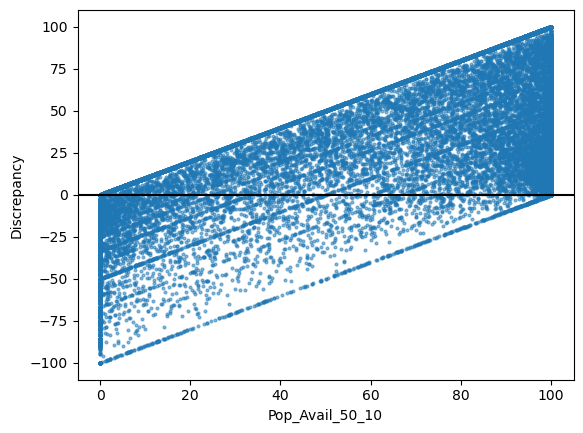

In [7]:
speed_data.plot.scatter(x="Pop_Avail_50_10", y="Discrepancy", s=4, alpha=0.5)
plt.axhline(y=0, color='k')
# Sum along z axis to see which one is more

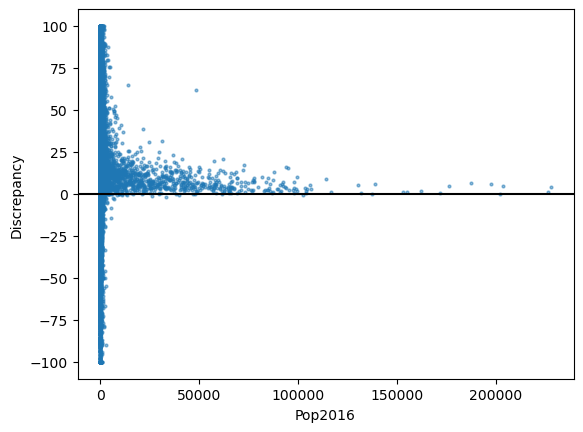

In [8]:
speed_data.plot.scatter(x="Pop2016", y="Discrepancy", s=4, alpha=0.5)
plt.axhline(y=0, color='k')
# Points close to zero discrepancy are also overestimated.

<Axes: xlabel='Pop2016', ylabel='tests'>

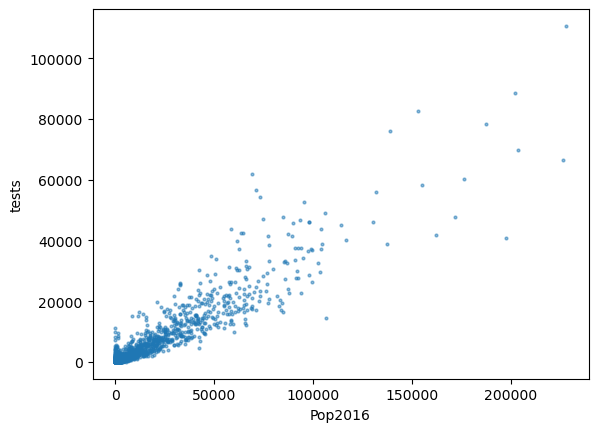

In [9]:
speed_data.plot.scatter(x="Pop2016", y="tests", s=4, alpha=0.5)
# plt.xlim(-1,100)
# plt.ylim(-1,100)
# Lots of regions with very low population

Text(0.5, 0, 'Number of sorted rows')

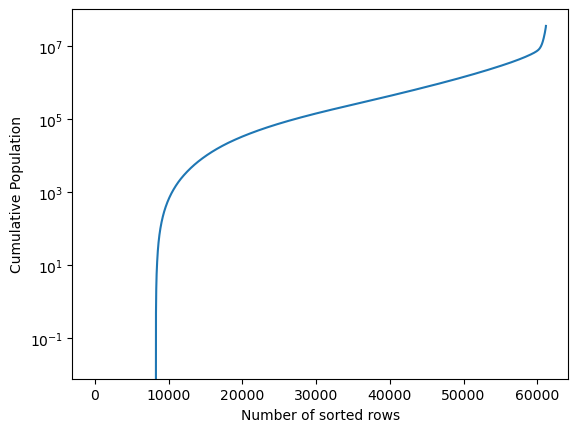

In [10]:
plt.plot(speed_data['Pop2016'].sort_values().cumsum().values)
plt.ylabel("Cumulative Population")
plt.yscale('log')
plt.xlabel("Number of sorted rows")

In [11]:
speed_data['tests'].sort_values()#.isna().cumsum()

61179    1.0
54754    1.0
41899    1.0
7557     1.0
41897    1.0
        ... 
61161    NaN
61162    NaN
61164    NaN
61171    NaN
61174    NaN
Name: tests, Length: 61180, dtype: float64

In [13]:
speed_data[speed_data["tests"].isna()].loc[:,['Pop2016', 'PRCODE', 'PCNAME', 'PCCLASS','PCPUID', 'HEXUID_PCPUID', 'Pop_Avail_50_10', 'is_rural']].sort_values('Pop2016')

,Pop2016,PRCODE,PCNAME,PCCLASS,PCPUID,HEXUID_PCPUID,Pop_Avail_50_10,is_rural
58382,0.026178,BC,NaN,,NaN,BC50821208,0.000000,True
9161,0.030303,NL,NaN,,NaN,NL46890542,0.000000,True
42223,0.031250,AB,NaN,,NaN,AB49231100,0.000000,True
49970,0.031250,AB,NaN,,NaN,AB49251103,0.000000,True
52939,0.032154,AB,NaN,,NaN,AB56251117,0.000000,True
...,...,...,...,...,...,...,...,...
731,2662.405690,BC,Vancouver,4,590973,BC49251227-590973,98.053115,False
1168,2894.000000,QC,Domaine-Ouellet,2,241399,241399,100.000000,False
521,4223.430880,ON,Hamilton,4,350349,ON43390797-350349,100.000000,False
549,5406.555556,ON,Kitchener,4,350419,ON43370805-350419,100.000000,False
